<a href="https://colab.research.google.com/github/saketlakhotia17/10daysofmlchallenge/blob/master/Day3(TFChallenge).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import nltk
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Dropout,Input,Activation,Embedding,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1Arob4b_sT6DQsEUC9SwD8_dEGdDGb0Ru'})
downloaded.GetContentFile('train.csv')

In [0]:
downloaded = drive.CreateFile({'id':'1sX3707RMFIqaEqjzNyc1NrG-L7B-5_-b'})
downloaded.GetContentFile('test.csv')

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [11]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
test.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [13]:
train.describe()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
train.isna().sum()


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [16]:
rel_data = train.drop("id",axis=1)
rel_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
cols_to_remove = test.columns[:2]
test_data = test.drop(cols_to_remove,axis=1)
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,:Dear god this site is horrible.,0,0,0,0,0,0
2,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [0]:
rel_data = rel_data.where(rel_data['comment_text'] !="")

test_data = test_data.where(test_data['comment_text'] !="")

rel_data['comment_text'] = rel_data.apply(lambda x: re.sub("[\n\t\b]"," ",x['comment_text']),axis=1)

test_data['comment_text'] = test_data.apply(lambda x: re.sub("[\n\t\b]"," ",x['comment_text']),axis=1)

rel_data['comment_text'] = rel_data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation)," ",x['comment_text']),axis=1)

test_data['comment_text'] = test_data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation)," ",x['comment_text']),axis=1)

rel_data['comment_text'] = rel_data.apply(lambda x: x['comment_text'].lower(),axis=1)

test_data['comment_text'] = test_data.apply(lambda x: x['comment_text'].lower(),axis=1)

# Preparing data for plotting class distribution in training dataset
class_counts = []
for col in rel_data.columns[1:]:
    class_counts.append((rel_data[col]!=0).sum())

In [20]:
cols_to_remove = test.columns[:2]
test_data = test.drop(cols_to_remove,axis=1)
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,:Dear god this site is horrible.,0,0,0,0,0,0
2,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [0]:
rel_data = rel_data.where(rel_data['comment_text'] !="")

test_data = test_data.where(test_data['comment_text'] !="")

rel_data['comment_text'] = rel_data.apply(lambda x: re.sub("[\n\t\b]"," ",x['comment_text']),axis=1)

test_data['comment_text'] = test_data.apply(lambda x: re.sub("[\n\t\b]"," ",x['comment_text']),axis=1)

rel_data['comment_text'] = rel_data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation)," ",x['comment_text']),axis=1)

test_data['comment_text'] = test_data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation)," ",x['comment_text']),axis=1)

rel_data['comment_text'] = rel_data.apply(lambda x: x['comment_text'].lower(),axis=1)

test_data['comment_text'] = test_data.apply(lambda x: x['comment_text'].lower(),axis=1)

Text(0, 0.5, 'Number of Records')

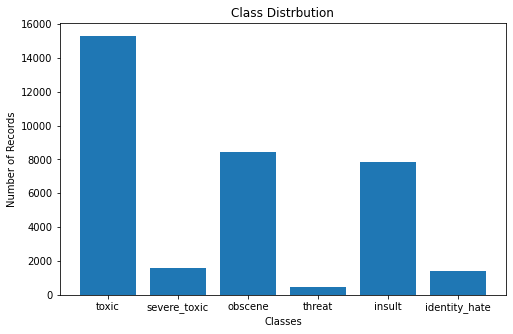

In [23]:
class_counts = []
for col in rel_data.columns[1:]:
    class_counts.append((rel_data[col]!=0).sum())

# Class Distribution
plt.figure(figsize=(8,5))
plt.bar(rel_data.columns[1:],class_counts)
plt.title("Class Distrbution")
plt.xlabel("Classes")
plt.ylabel("Number of Records")

In [28]:
import nltk
nltk.download('all')

rel_data['comments_tokenized'] = rel_data.apply(lambda x: nltk.tokenize.word_tokenize(x['comment_text']),axis=1)

test_data['comments_tokenized'] = test_data.apply(lambda x: nltk.tokenize.word_tokenize(x['comment_text']),axis=1)

stopwords = nltk.corpus.stopwords.words("english")
rel_data['comments_nostop'] = rel_data.apply(lambda x: [word for word in x['comments_tokenized'] if word not in stopwords],axis=1)

stopwords = nltk.corpus.stopwords.words("english")
test_data['comments_nostop'] = test_data.apply(lambda x: [word for word in x['comments_tokenized'] if word not in stopwords],axis=1)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [29]:
rel_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comments_tokenized,comments_nostop
0,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,..."
1,d aww he matches this background colour i m s...,0,0,0,0,0,0,"[d, aww, he, matches, this, background, colour...","[aww, matches, background, colour, seemingly, ..."
2,hey man i m really not trying to edit war it...,0,0,0,0,0,0,"[hey, man, i, m, really, not, trying, to, edit...","[hey, man, really, trying, edit, war, guy, con..."
3,more i can t make any real suggestions on im...,0,0,0,0,0,0,"[more, i, can, t, make, any, real, suggestions...","[make, real, suggestions, improvement, wondere..."
4,you sir are my hero any chance you remember...,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page]"


In [30]:
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comments_tokenized,comments_nostop
0,thank you for understanding i think very high...,0,0,0,0,0,0,"[thank, you, for, understanding, i, think, ver...","[thank, understanding, think, highly, would, r..."
1,dear god this site is horrible,0,0,0,0,0,0,"[dear, god, this, site, is, horrible]","[dear, god, site, horrible]"
2,somebody will invariably try to add relig...,0,0,0,0,0,0,"[somebody, will, invariably, try, to, add, rel...","[somebody, invariably, try, add, religion, rea..."
3,it says it right there that it is a type ...,0,0,0,0,0,0,"[it, says, it, right, there, that, it, is, a, ...","[says, right, type, type, institution, needed,..."
4,before adding a new product to the lis...,0,0,0,0,0,0,"[before, adding, a, new, product, to, the, lis...","[adding, new, product, list, make, sure, relev..."


In [0]:
max_features = 20000
tokenizer = tf.keras.preprocessing.text.Tokenizer(max_features)

tokenizer.fit_on_texts(rel_data['comments_nostop'])

tokenized_train = tokenizer.texts_to_sequences(rel_data['comments_nostop'])

tokenized_train[5]

[2526, 25, 16, 2079, 25, 891, 4]

tokenized_test = tokenizer.texts_to_sequences(test_data['comments_nostop'])

tokenized_test[12]

[627, 1220, 22, 845, 284, 10208, 627, 2730, 627, 2682, 25, 69, 703, 9231]

rel_data['clean_comment_len'] = rel_data.apply(lambda x: len(x['comments_nostop']),axis=1)

In [33]:
rel_data.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comments_tokenized,comments_nostop,clean_comment_len
0,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...",27
1,d aww he matches this background colour i m s...,0,0,0,0,0,0,"[d, aww, he, matches, this, background, colour...","[aww, matches, background, colour, seemingly, ...",14
2,hey man i m really not trying to edit war it...,0,0,0,0,0,0,"[hey, man, i, m, really, not, trying, to, edit...","[hey, man, really, trying, edit, war, guy, con...",21
3,more i can t make any real suggestions on im...,0,0,0,0,0,0,"[more, i, can, t, make, any, real, suggestions...","[make, real, suggestions, improvement, wondere...",52
4,you sir are my hero any chance you remember...,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page]",5


In [34]:
max_len = rel_data['clean_comment_len'].max()
max_len

1250

Text(0, 0.5, 'Number of Comments')

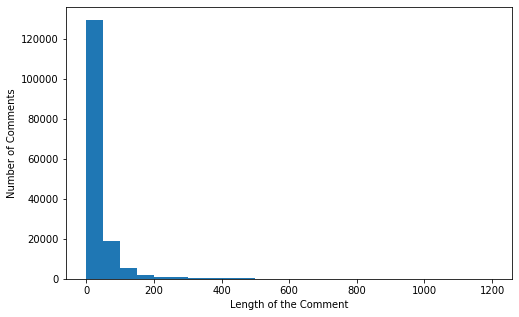

In [35]:
# Comment length distribution
plt.figure(figsize=(8,5))
plt.hist(rel_data['clean_comment_len'],bins=np.arange(0,max_len,50))
plt.xlabel("Length of the Comment")
plt.ylabel("Number of Comments")

In [36]:
maxSeqLen = 200

train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train,maxlen=maxSeqLen)

test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test,maxlen=maxSeqLen)

train.shape

(159571, 200)

In [37]:
test.shape

(63978, 200)

In [0]:
target_cols = raw_data.columns[2:]
y = rel_data[target_cols].values
y.shape

In [0]:
y_test = test_data[target_cols].values
y_test.shape

In [0]:
inp = Input(shape=(maxSeqLen,))
x = Embedding(max_features,128)(inp)
x = LSTM(60,return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6,activation="sigmoid")(x)
model = Model(inputs=inp,outputs=x)

In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

In [0]:
model.compile(Adam(),loss="binary_crossentropy",metrics=["accuracy"])

In [0]:
batch_size = 32
epochs = 5

# Calling the .fit() method to begin the training
model.fit(train,y,batch_size,epochs,validation_split=0.1)

In [0]:
loss, accuracy = model.evaluate(test,y_test)

In [0]:
print("Your model attained an accuracy of {}% and a loss of {} on the test dataset".format(round(accuracy*100,2),round(loss,5)))

In [0]:
pred = model.predict(test)
roc_auc_score(y_test,pred)